# Neural Network Final Model - Gosan, South Korea

In [1]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'GSN', 'This script is only for Gosan, South Korea. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Gosan, South Korea.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
2201,2009-09-20 13:00:00,1.0,-4.639429,-1.478975,-3.167312,-0.118478,-6.299684,-4.617666,-0.887180,-5.655238,...,3.067794,6.260865,12.663158,-8.391231,-7.502886,-5.521194,0.185333,-2.176545,7.417577,-2.480943
8751,2015-10-13 21:00:00,1.0,-0.842253,-0.324101,-6.972918,-0.082579,-3.463887,-2.583754,1.123215,0.927092,...,-2.721830,-3.073485,-25.566116,-17.329433,-3.663999,3.800370,-1.685444,2.815736,0.705808,1.793948
6314,2013-02-25 03:00:00,1.0,-3.558226,0.273328,-3.736411,0.436859,-2.516667,-5.722817,-0.794021,-5.582145,...,-6.786022,-15.069006,-28.115116,-16.860426,-19.419266,-7.222214,-7.245540,1.309191,-5.776015,-6.145729
2789,2010-02-13 03:00:00,1.0,4.354667,2.723719,-5.036480,3.423049,1.087838,-0.413897,-1.590626,-1.346502,...,-8.361807,-9.230078,-0.892438,-4.785652,9.306103,6.682244,3.172190,2.256864,-7.221292,-1.457094
6818,2013-09-17 17:00:00,1.0,-5.126628,0.061237,1.999852,-1.234875,-9.768538,-9.745469,0.319264,-6.296290,...,-8.747849,4.627377,-4.698784,4.675242,-5.627661,7.566577,-3.309209,0.911871,1.816815,-4.942596


In [4]:
train_data = data[(data['time'].dt.year >= 2009) & (data['time'].dt.year <= 2013)]
val_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2014)]
test_data = data[(data['time'].dt.year >= 2015) & (data['time'].dt.year <= 2017)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2009-01-01 01:00:00 -> 2013-12-30 09:00:00. Length: 5763
Val range: 2014-01-03 19:00:00 -> 2014-12-31 23:00:00. Length: 933
Test range: 2015-01-01 01:00:00 -> 2017-12-31 23:00:00. Length: 2824


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.0001, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=False,
                         learning_rate_init=0.0001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.823
Precision on Validation Set = 0.739
Recall on Training Set = 1.000
Recall on Validation Set = 1.000
F1 Score on Training Set = 0.903
F1 Score on Validation Set = 0.850


In [6]:
# evaluating model on test set
y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.757
Recall on Testing Set = 1.000
F1 Score on Testing Set = 0.862


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_GSN.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_GSN.joblib']

### Assessing Feature Importance

In [8]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance (Testing Set)')

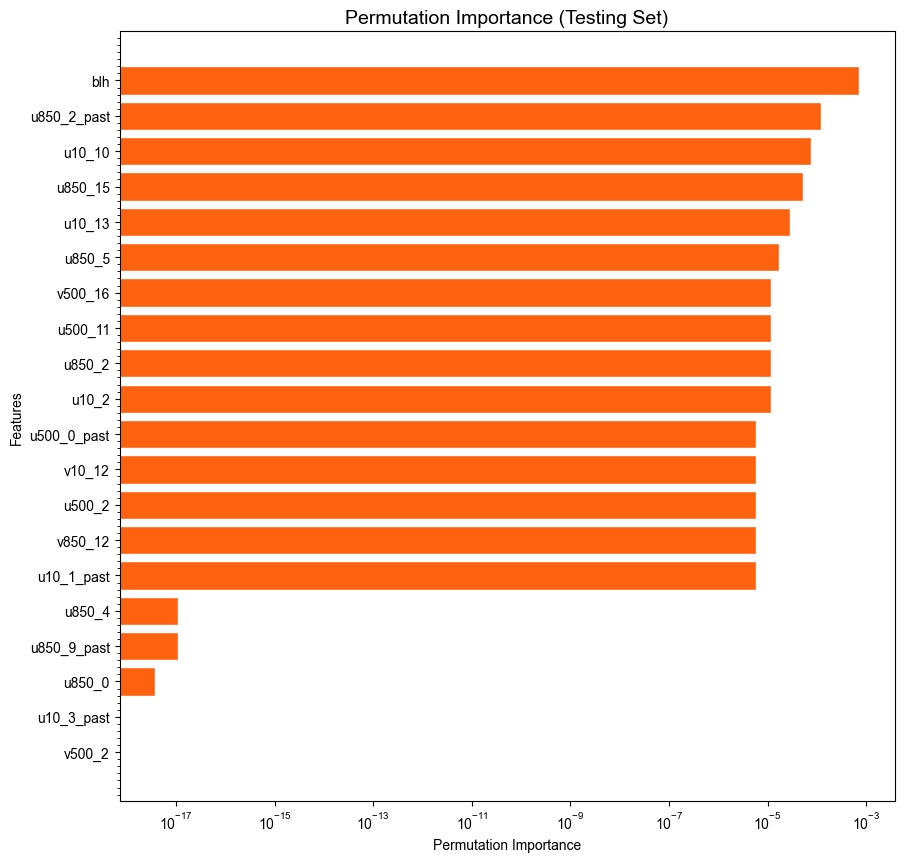

In [9]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(10, 10))
sns.set_theme(style='ticks', font='Arial')
ax.minorticks_on()

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:], color='#FF620E')

ax.set_xscale('log')

ax.set_ylabel('Features')
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance (Testing Set)', fontsize=14)